In [33]:
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns
import pandas as pd
from sets import Set
import numpy as np
import re

In [2]:
data = []
with open('data.csv', 'rw') as archivo:
    for row in archivo:
        data.append(list(map(lambda x: x.lower(), row.split(', ')[:4])))
    
df = pd.DataFrame(data, columns=['year','opcode', 'field', 'authors'])
df.to_pickle('data.df')
# df = pd.read_pickle('data.df')
df

,year,opcode,field,authors
0,1992,b368,nucl.phys.,horne & horowitz
1,1992,b278,phys. lett.,mikovic
2,1991,a6,mod. phys. lett.,huitu & nemeschansky
3,1992,b373,nucl.phys.,witten
4,1991,a6,mod.phys.lett.,intriligator
5,1991,a6,mod. phys. lett.,ooguri & sasakura
6,1992,a7,int. j. mod. phys.,leclair & smirnov
7,1992,b372,nucl.phys.,griffin
8,1992,b274,phys. lett.,sen
9,1992,b372,nucl.phys.,lerche & smit & warner


In [3]:
def get_pares(lista):
    return [(lista[x],lista[y]) for x in range(len(lista)) for y in range(x+1,len(lista))]

In [6]:
nodos = []
for col in df.index:
    nodos += list(map(lambda x: re.sub(r'\W+', '', x), df.iloc[col].authors.split(" & ")))
nodos = Set(nodos)
G = nx.MultiGraph()
G.add_nodes_from(nodos)
for col in df.index:
    a = list(map(lambda x: re.sub(r'\W+', '', x), df.iloc[col].authors.split(" & ")))
    G.add_edges_from(get_pares(a))
# nx.draw_networkx(G,)
# plt.show()

In [18]:
print 'Cantidad de nodos:', G.number_of_nodes()
print 'Cantidad de aristas:', G.number_of_edges()
# print G.nodes()
# print G.degree

Cantidad de nodos: 3943
Cantidad de aristas: 13205


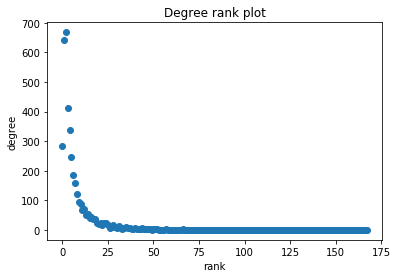

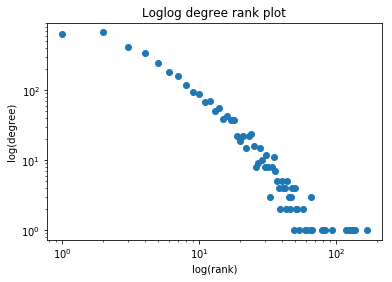

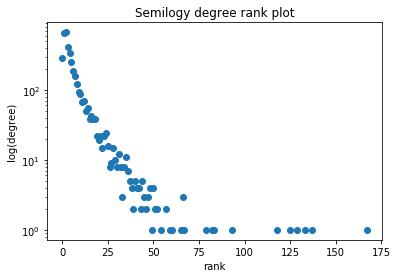

In [48]:
degree_sequence=list(sorted(map(lambda x: x[1],nx.degree(G)),reverse=True)) # degree sequence
# print "Degree sequence", degree_sequence
grados = np.array([0]*max(degree_sequence)+[0])
for a in degree_sequence:
    grados[a] += 1
# print grados


plt.plot(grados, 'o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")
plt.show()

plt.loglog(grados, 'o')
plt.title("Loglog degree rank plot")
plt.ylabel("log(degree)")
plt.xlabel("log(rank)")
plt.show()

plt.semilogy(grados, 'o')
plt.title("Semilogy degree rank plot")
plt.ylabel("log(degree)")
plt.xlabel("rank")
plt.show()
